# McStasScript
McStasScript allows writing and running McStas simulations directly from python. The API covers almost all features of McStas 2.X, but lacks a few for McStas 3.X releases.

Written by Mads Bertelsen while working at ESS DMSC

Funded by PaNOSC and a part of PaNOSC work package 5.

### Installation
McStasScript is open source and available here: https://github.com/PaNOSC-ViNYL/McStasScript

Easy to install, install McStas as normal and then McStasScript can be installed with:
```
pip install McStasScript --upgrade
```

![normal](figures/Slide1.png)

![McStasScript](figures/Slide2.png)

# Live demo of McStasScript
Here we will set up an instrument simulation together and execute it from the slides!
First we import the package.

In [1]:
from mcstasscript.interface import instr, functions, plotter

## Configuration
Before using McStasScript for the first time, it needs to be configured to find your McStas and/or McXtrace installation.

In [2]:
configurator = functions.Configurator()
configurator.set_mcrun_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/")
configurator.set_mcstas_path("/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1")
print(configurator)

Configurator:
 paths:
  mcrun_path: /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1/bin/
  mcstas_path: /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1
  mcxtrace_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/
  mxrun_path: /Applications/McXtrace-1.5.app/Contents/Resources/mcxtrace/1.5/bin/
 other:
  characters_per_line: 85



## Create instrument objects
The main class is the McStas_instr, used for creating instrument objects.

In [3]:
instrument = instr.McStas_instr("demo", author="Mads Bertelsen")

## Help from the instrument object
The instrument object knows about your available McStas components, and has help methods available.

In [4]:
instrument.show_components()

Here are the available component categories:
 contrib
 misc
 monitors
 obsolete
 optics
 samples
 sources
 union
Call show_components(category_name) to display


In [5]:
instrument.show_components("sources")

Here are all components in the sources category.
 Adapt_check     Moderator           Source_Optimizer   Source_gen
 ESS_butterfly   Monitor_Optimizer   Source_adapt       Source_simple
 ESS_moderator   Source_Maxwell_3    Source_div         


In [6]:
instrument.component_help("Moderator")

 ___ Help Moderator _________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
radius = 0.07 [m] // Radius of source
Emin [meV] // Lower edge of energy distribution
Emax [meV] // Upper edge of energy distribution
dist = 0.0 [m] // Distance from source to the focusing rectangle
focus_xw = 0.02 [m] // Width of focusing rectangle
focus_yh = 0.02 [m] // Height of focusing rectangle
t0 = 37.15 [mus] // decay constant for low-energy neutrons
Ec = 9.0 [meV] // Critical energy, below which the flux decay is constant
gamma = 39.1 [meV] // energy dependence of decay time
target_index = 1 [1] // relative index of component to focus at, e.g. next is 
                        +1 this is used to compute 'dist' automatically. 
flux = 1.0 [1/(s cm 2 st meV)] // flux
-------------------------------------------------------------------------------------


## Adding components
McStas simulations rely on a sequence of components, these can be added to the instrument object with the *add_component* method. These return an instrument object that can be used to modify the component further.

In [7]:
src = instrument.add_component("source", "Source_div")
instrument.print_components()

source Source_div AT (0, 0, 0) ABSOLUTE


In [8]:
print(src)

COMPONENT source = Source_div
  xwidth : Required parameter not yet specified
  yheight : Required parameter not yet specified
  focus_aw : Required parameter not yet specified
  focus_ah : Required parameter not yet specified
AT [0, 0, 0] ABSOLUTE



The component parameters become python attributes on the component object.

In [9]:
src.xwidth = 0.1
src.yheight = 0.05
src.focus_aw = 1.2
src.focus_ah = 2.3
print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 2.3 [deg]
AT [0, 0, 0] ABSOLUTE



Notice the attributes on component objects auto complete and wrong attibutes are not allowed.

In [10]:
src.focus_ah = 6

### All information about a component
The *show_parameters* method is good for getting an overview of the current state of the component parameters, as it will also show the default values.

In [11]:
src.show_parameters()

 ___ Help Source_div ________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
xwidth = 0.1 [m] // Width of source
yheight = 0.05 [m] // Height of source
focus_aw = 1.2 [deg] // FWHM (Gaussian) or maximal (uniform) horz. width 
                        divergence 
focus_ah = 6 [deg] // FWHM (Gaussian) or maximal (uniform) vert. height 
                      divergence 
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons.
lambda0 = 0.0 [Ang] // Mean wavelength of neutrons (only relevant for E0=0)
dlambda = 0.0 [Ang] // Wavelength half spread of neutrons.
gauss = 0.0 [0|1] // Criterion
flux = 1.0 [1/(s cm 2 st energy_unit)] // flux per energy unit, Angs or meV
-------------------------------------------------------------------------------------


## Add instrument parameters
Its also possible to add instrument parameters, and these can be used directly when setting component parameters.

In [12]:
instrument.add_parameter("wavelength", value=2.0, comment="Wavelength in [Ang]")
instrument.add_parameter("int", "order", value=1, comment="Monochromator order, integer")
instrument.show_parameters()

    wavelength  =  2.0  // Wavelength in [Ang]
int order       =  1    // Monochromator order, integer


In [13]:
src.lambda0 = "wavelength"
src.dlambda = "0.01*wavelength"
print(src)

COMPONENT source = Source_div
  xwidth = 0.1 [m]
  yheight = 0.05 [m]
  focus_aw = 1.2 [deg]
  focus_ah = 6 [deg]
  lambda0 = wavelength [Ang]
  dlambda = 0.01*wavelength [Ang]
AT [0, 0, 0] ABSOLUTE



### Setting component positions
When creating a new component, one can specify its position and rotation. 

In [14]:
guide = instrument.add_component("guide", "Guide_gravity", AT=[0,0,1], RELATIVE=src)

In [15]:
guide.w1 = 0.05
guide.h1 = 0.05
guide.l = 8.0
guide.m = 3.5
guide.G = -9.82

print(guide)

COMPONENT guide = Guide_gravity
  w1 = 0.05 [m]
  h1 = 0.05 [m]
  l = 8.0 [m]
  m = 3.5 [1]
  G = -9.82 [m/s2]
AT [0, 0, 1] RELATIVE source



One can always set the positon and rotation of component objects with the appropriate methods at a later point.

In [16]:
guide.set_AT([0, 0, 2], RELATIVE="source")

### Adding initialize code
Its possible to add lines of C code to the initialize section of the written McStas file, but its equally possible to just perform these calculations directly in python. Here I show how calculate rotation of a monochromator before we add such a component.

In [17]:
instrument.add_declare_var("double", "mono_Q", value=2*3.14159/1.714) # Q for Ge 311
instrument.add_declare_var("double", "wavevector")
instrument.append_initialize("wavevector = 2.0*PI/wavelength;")

instrument.add_declare_var("double", "mono_rotation")
instrument.append_initialize("mono_rotation = asin(mono_Q/(2.0*wavevector))*RAD2DEG;")
instrument.append_initialize('printf("monochromator rotation = %g deg\\n", mono_rotation);')

### Adding a monochromator
We can now add a monochromator that use the calculated rotation.

In [18]:
mono = instrument.add_component("mono", "Monochromator_flat")

In [19]:
mono.zwidth = 0.05
mono.yheight = 0.08
mono.Q = "mono_Q"
mono.set_AT([0, 0, 8.5], RELATIVE=guide)
mono.set_ROTATED([0, "mono_rotation", 0], RELATIVE="guide")

print(mono)

COMPONENT mono = Monochromator_flat
  zwidth = 0.05 [m]
  yheight = 0.08 [m]
  Q = mono_Q [1/angstrom]
AT [0, 0, 8.5] RELATIVE guide
ROTATED [0, 'mono_rotation', 0] RELATIVE guide



Need to set the beam direction to the direction of the scattered beam

In [20]:
beam_direction = instrument.add_component("beam_dir", "Arm", AT_RELATIVE=mono)
beam_direction.set_ROTATED([0, "mono_rotation", 0], RELATIVE=mono)

### Adding a sample
Now we can set up a simple powder sample to get some mildly interesting data.

In [21]:
sample = instrument.add_component("sample", "PowderN", AT=[0,0,1.1], RELATIVE="beam_dir")

In [22]:
sample.radius = 0.015
sample.yheight = 0.05
sample.reflections = '"Na2Ca3Al2F14.laz"'
print(sample)

COMPONENT sample = PowderN
  reflections = "Na2Ca3Al2F14.laz" []
  radius = 0.015 [m]
  yheight = 0.05 [m]
AT [0, 0, 1.1] RELATIVE beam_dir



### Adding a few monitors
At the end we add a few monitors, a two theta banana detector and a transmission PSD.

In [23]:
banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 2.0
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[5 175] bins=150, banana"'

mon = instrument.add_component("monitor", "PSD_monitor")
mon.nx = 100
mon.ny = 100
mon.filename = '"psd.dat"'
mon.xwidth = 0.05
mon.yheight = 0.08
mon.restore_neutron = 1
mon.set_AT([0,0,0.1], RELATIVE=sample)

### Checking our instrument object
Before running our simulation we can check the contents of the instrument object and ensure its reasonable.

In [24]:
instrument.print_components()

source   Source_div         AT      (0, 0, 0)             ABSOLUTE         
guide    Guide_gravity      AT      (0, 0, 2)             RELATIVE source  
mono     Monochromator_flat AT      (0, 0, 8.5)           RELATIVE guide    
                            ROTATED (0, mono_rotation, 0) RELATIVE guide
beam_dir Arm                AT      (0, 0, 0)             RELATIVE mono     
                            ROTATED (0, mono_rotation, 0) RELATIVE mono
sample   PowderN            AT      (0, 0, 1.1)           RELATIVE beam_dir
banana   Monitor_nD         AT      (0, 0, 0)             RELATIVE sample  
monitor  PSD_monitor        AT      (0, 0, 0.1)           RELATIVE sample  


In [25]:
instrument.show_parameters()

    wavelength  =  2.0  // Wavelength in [Ang]
int order       =  1    // Monochromator order, integer


### Runnig our simulation
Now we can run the simulation directly from python.

In [26]:
data = instrument.run_full_instrument(ncount=5E6, foldername="data_folder/mcstas_basics",
                                      increment_folder_name=True,
                                      parameters={"wavelength" : 2.8})

INFO: Using directory: "/Users/madsbertelsen/McStas/McStas_teaching/Schools/ESS_March_2022_IDS_Scipp_McStas_intro/Day1_Wednesday_March_16th/05_McStasScript/data_folder/mcstas_basics_4"
INFO: Regenerating c-file: demo.c
CFLAGS=
INFO: Recompiling: ./demo.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
1 warning generated.
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy demo.instr in dataset /Users/madsbertelsen/McStas/McStas_teaching/Schools/ESS_March_2022_IDS_Scipp_McStas_intro/Day1_Wednesday_March_16th/05_McStasScript/data_folder/mcstas_basics_4

      monochromator rotation = 54.766 deg
Opening input file '/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//data/Na2Ca3Al2F14.laz' (Table_Read_Offset)
Table from file 'Na2Ca3Al2F14.laz' (block 1) is 841 x 18 (x=1:20), constant step. interpolation: linear
  '# TITLE *-Na2Ca3Al2F14-[I213] Courbion, G.;Ferey, G.[1988] Standa

### Plotting the data
The *run_full_instrument* method returns a data object that we can plot.

In [27]:
print(data)

[
McStasData: banana type: 1D  I:1.14632e-06 E:3.11891e-08 N:4146, 
McStasData: monitor type: 2D  I:6.31428e-05 E:4.79972e-07 N:42048]


Plotting data with name banana
Plotting data with name monitor


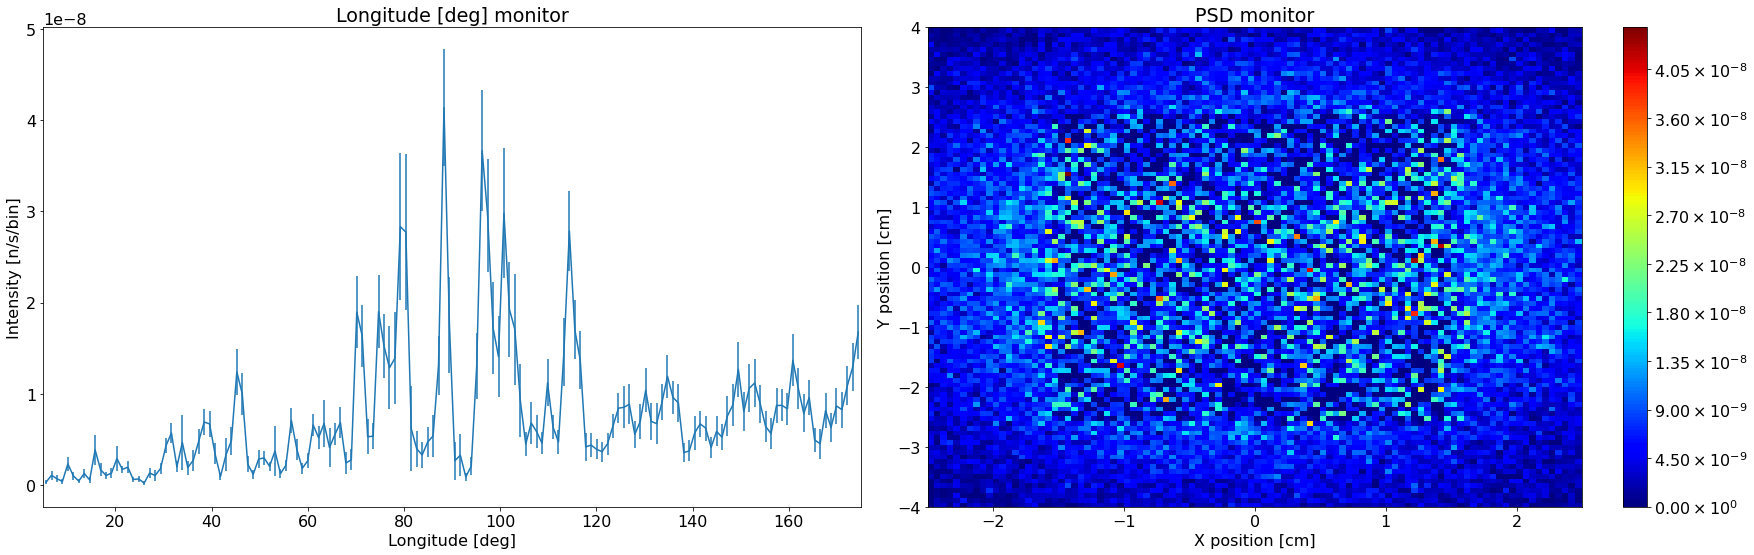

In [28]:
plotter.make_sub_plot(data, fontsize=16, figsize=(25, 8))

### Plotting interface
A widget interface is also available for plotting.

In [29]:
%matplotlib widget
plotter.interface(data)

### Setting plotting options
Its also possible to adjust the way data is plotted, and these preferences are stored in the data object.

In [30]:
functions.name_plot_options("banana", data, left_lim=90, right_lim=150)
functions.name_plot_options("monitor", data, log=True, orders_of_mag=3)
plotter.make_sub_plot(data, fontsize=12, figsize=(9, 4))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Plotting data with name banana
Plotting data with name monitor


### Access to the underlying data
The underlying data is read from the McStas data files and imported as numpy arrays.

In [31]:
import numpy as np
banana = functions.name_search("banana", data)
print(banana)

McStasData: banana type: 1D  I:1.14632e-06 E:3.11891e-08 N:4146


In [32]:
print(banana.Intensity[1:10])

[1.06349022e-09 6.89541136e-10 3.89983655e-10 2.30868189e-09
 1.00538643e-09 4.31648199e-10 1.26826913e-09 5.58864653e-10
 3.85346681e-09]


### Plot with matplotlib

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(banana.xaxis, banana.Intensity)
plt.xlabel("Two theta [deg]")
plt.ylabel("Intensity [n/s/bin]")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Instrument visualization
With local installations its possible to run visualization of the instrument.

In [35]:
instrument.show_instrument(parameters={"wavelength": 2.0})


loading system configuration
      monochromator rotation = 35.6922 deg

INFO: Using directory: "demo_20220316_081602"
INFO: Regenerating c-file: demo.c
CFLAGS=
INFO: Recompiling: ./demo.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
*t0;
^~~
1 warning generated.
INFO: ===
(negative time, miss next components, rounding errors, Nan, Inf).
instrument definition parsed
reading particle data...
      monochromator rotation = 35.6922 deg

Component                         source AT (0,0,0)    0 m from origin
Component                          guide AT (0,0,2)    2 m from origin
Component                           mono AT (0,0,10.5)    10.5 m from origin
Component                       beam_dir AT (0,0,10.5)    10.5 m from origin
Component                         sample AT (1.04245,0,10.8511)    11.6 m from origin
Component                         banana AT (1.04245,0,10.8511)    11.6 m from origin
Component                        monitor AT (1.13722,0,10.8831)   

## Final remarks
McStasScript provides a new way to use McStas from python!

A full tutorial exist as Jupyter Notebooks, this presentation was a condensed version of the first part called McStas_basics.
The tutorial covers both how to use McStasScript and the Union components.

You can get access to the tutorial as part of our IKON Python course, or by cloning the McStasScript github repo.

There is a major release of McStasScript around the corner that will change the syntax slightly, mainly around running the simulation. The documentation was reworked for the upcoming release [https://mads-bertelsen.github.io](https://mads-bertelsen.github.io), old documentation available on github as pdf [https://github.com/PaNOSC-ViNYL/McStasScript](https://github.com/PaNOSC-ViNYL/McStasScript).


## Exercise

Translate a simple instrument file to McStasScript manually.

Use a for-loop in python to add a small series of similar components, for example guide pieces.